# Big Movers

In [1]:
from IPython.display import clear_output, display, HTML
from urllib.parse import urlencode
from datetime import datetime, timedelta
from collections import defaultdict
import queue
import requests
import threading
import pandas as pd
import itertools
from math import isnan
import pytz
import json
import csv
import matplotlib.pyplot as plt
from matplotlib import style
from time import sleep
    
style.use('ggplot')

TOP_ITEMS_COUNT = 10
DATA_TIMEZONE = pytz.timezone("US/Eastern")
CLIENT_TIMEZONE = pytz.timezone('America/Los_Angeles')
periods = [1, 5, 15, 30, 60, "All day"]
now = datetime.now(tz=CLIENT_TIMEZONE)
weekday = now.isoweekday()
if weekday > 5:
    now = (now - timedelta(days=weekday - 5)).replace(hour=15)

In [2]:
def get_symbols():
    with open("n13_symbols.csv", "r") as f:
        symbols = f.read().split()
    return list(set(symbols))
symbols = get_symbols()
len(symbols)

3198

In [3]:
def get_minute_data(symbol, now):
    now = now.replace(second=0, microsecond=0)
    start = now.replace(hour=6, minute=30)
    if start > now:
        raise ValueError("It's too early")
    
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), now.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(symbol, page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        return
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    df = pd.Series(quote.get('close'), index=[datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times])
    return df

minute_data = get_minute_data('SRCE', now) # SRCE
minute_data[:10]

2017-06-16 06:30:00-07:00    48.459999
2017-06-16 06:31:00-07:00          NaN
2017-06-16 06:32:00-07:00          NaN
2017-06-16 06:33:00-07:00          NaN
2017-06-16 06:34:00-07:00          NaN
2017-06-16 06:35:00-07:00          NaN
2017-06-16 06:36:00-07:00          NaN
2017-06-16 06:37:00-07:00          NaN
2017-06-16 06:38:00-07:00          NaN
2017-06-16 06:39:00-07:00          NaN
dtype: float64

In [4]:
def get_period_change(series, period):
    """
    2017-06-02 09:48:00-07:00          NaN
    2017-06-02 09:49:00-07:00    46.834999
    2017-06-02 09:50:00-07:00          NaN
    2017-06-02 09:51:00-07:00          NaN
    2017-06-02 09:52:00-07:00          NaN
    2017-06-02 09:53:00-07:00          NaN
    2017-06-02 09:54:00-07:00          NaN
    2017-06-02 09:55:00-07:00          NaN
    2017-06-02 09:56:00-07:00    46.770000
    """
    start_value = end_value = change = None
    if type(period) is int:
        # get the latest valid value from the previous period
        prev_series = series[:-period]
        li = prev_series.last_valid_index()
        if li:
            start_value = prev_series[li]
            
        period_series = series[-period:]
        li = period_series.last_valid_index()
        if li:
            end_value = period_series[li]
    else:
        fi = series.first_valid_index()
        if fi:
            start_value = series[fi]   
    
        li = series.last_valid_index()
        if li:
            end_value = series[li]
    if None not in (start_value, end_value):
        change = (end_value / start_value - 1) * 100
    return change
    
get_period_change(minute_data, 5)

0.020404737822854457

In [5]:
def load_data(symbols, time):
    
    num_worker_threads = 100
    
    def worker():
        while True:
            symbol = q.get()
            if symbol is None:
                break
            
            # GET DATA
            data = get_minute_data(symbol, time)
            if data is not None:
                r.put((symbol, data))
            
            q.task_done()

    q = queue.Queue() # queue with arguments for the 'get_transactions' function
    r = queue.Queue() # queue with raw responses

    threads = []
    for i in range(num_worker_threads):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)

    for symbol in symbols:
        q.put(symbol)

    # block until all tasks are done
    q.join()

    # stop workers
    for i in range(num_worker_threads):
        q.put(None)

    for t in threads:
        t.join()
    
    # get and save data
    period_changes = defaultdict(list)
    minute_data = {}    
    symbols_saved = []
    while True:
        try:
            symbol, data = r.get(block=False)
        except queue.Empty:
            break
        else:
            symbols_saved.append(symbol)
            minute_data[symbol] = data
            for p in periods:
                period_changes[p].append(get_period_change(data, p))
                
    period_changes = pd.DataFrame(period_changes, index=symbols_saved)
    
    return period_changes, minute_data

r, e = load_data(("SRCE", "GOOG"), now)
r

,All day,1,5,60,30,15
GOOG,-0.082929,0.130008,0.076679,0.028742,0.030873,0.040460
SRCE,1.134955,0.020405,0.020405,0.430326,0.020405,0.020405


,1,5,15,30,60,All day
0,IFMK 8.77%,HRMNW 11.91%,PAVM 18.32%,PAVM 18.62%,HRMNW 17.55%,IMRNW 44.52%
1,HRMNW 8.05%,IFMK 10.58%,HRMNW 17.49%,HRMNW 17.49%,PAVM 13.41%,ADOM 32.79%
2,ARDM 7.68%,SBPH 8.86%,CLSN 12.68%,LAWS 12.47%,LAWS 12.47%,AVGR 29.68%
3,SBPH 5.56%,WVE 5.25%,LAWS 11.36%,CLSN 11.39%,TRCH 11.27%,HRMNW 20.84%
4,WVE 4.99%,CATS 4.51%,SBPH 11.24%,SBPH 9.28%,CLSN 10.73%,UNFI 16.37%
5,DCTH 4.79%,AKAO 4.25%,WHLM 8.46%,WVE 8.65%,WVE 8.93%,MRDN 15.17%
6,NIHD 4.17%,PFMT 4.07%,WVE 8.37%,WHLM 8.46%,SMRT 8.52%,GLMD 13.86%
7,BSPM 3.52%,INTG 4.03%,TRCH 8.22%,AVGR 7.84%,WHLM 8.46%,PAVM 13.69%
8,ABIL 3.36%,NIHD 4.02%,SMRT 8.18%,SMRT 7.50%,AVGR 7.94%,HIIQ 12.95%
9,EGAN 3.22%,PERF 3.78%,MRDN 7.37%,TRCH 7.48%,VBFC 7.65%,LINU 12.29%


,1,5,15,30,60,All day
0,CMCT -5.80%,RNVAZ -11.61%,VLRX -13.64%,YTEN -12.93%,DGLT -14.21%,RNVAZ -20.81%
1,AMTX -5.00%,YTEN -7.91%,RNVAZ -12.74%,RNVAZ -12.74%,VLRX -13.36%,BSPM -15.36%
2,URGN -4.56%,SNOAW -7.01%,DGLT -10.44%,DGLT -11.89%,RNVAZ -12.74%,AHGP -14.58%
3,SAEX -4.22%,PAACW -6.90%,CFBI -9.88%,CFBI -10.07%,CFBI -10.07%,ADMP -14.40%
4,WMIH -4.17%,APWC -6.56%,CFBK -8.15%,ORPN -9.47%,ASV -9.34%,VLRX -14.19%
5,ORPN -3.91%,TORM -6.17%,WCFB -7.95%,CFBK -8.55%,PXS -9.32%,SKYS -13.75%
6,OCC -3.85%,GALT -5.00%,YTEN -7.91%,EKSO -8.01%,CFBK -8.15%,WHLRW -13.35%
7,CFCOU -3.38%,MMDMR -5.00%,BIOP -7.73%,WCFB -7.95%,EKSO -8.01%,OPGNW -12.29%
8,SNDE -3.33%,SRSC -4.81%,ASV -7.72%,ALT -7.37%,WCFB -7.95%,AXARW -11.54%
9,MARA -3.29%,URGN -4.56%,SVBI -7.10%,BIOP -7.28%,BIOP -7.28%,SGOC -11.54%


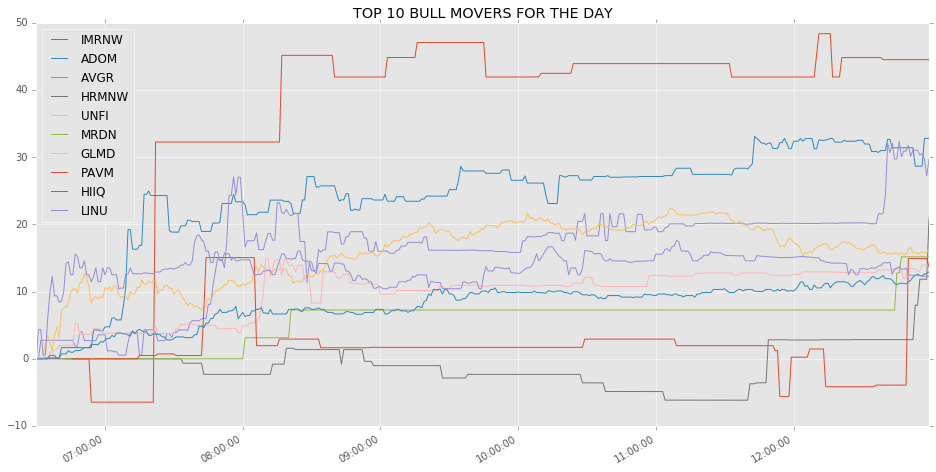

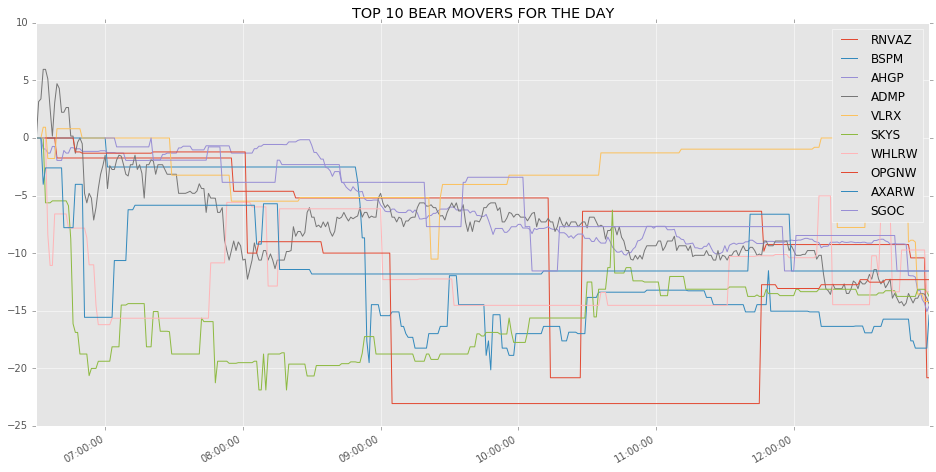

period 0:01:17.012204
IVENC {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
RDIB {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
SBNYW {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}
TCBIW {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-e8ef39024671>", line 12, in <module>
    period_changes, minute_data = load_data(symbols, now)
  File "<ipython-input-5-e9d68ce5b210>", line 31, in load_data
    q.join()
  File "/usr/lib/python3.5/queue.py", line 83, in join
    self.all_tasks_done.wait()
  File "/usr/lib/python3.5/threading.py", line 293, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent

KeyboardInterrupt: 

IRDMB {'chart': {'error': {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}, 'result': None}}


In [6]:
prev_time = None

while True:
    # now = datetime.now(tz=CLIENT_TIMEZONE)
    start = datetime.now()
    
    if prev_time:
        seconds_since_update = (start - prev_time).seconds
        if seconds_since_update < 60:
            sleep(60 - seconds_since_update)    
    
    period_changes, minute_data = load_data(symbols, now)
    
    # calc bull&bear moves
    bull = {}
    bear = {}
    top_bull_movers = []
    top_bear_movers = []
    for p in periods:
        changes_bear = period_changes.sort_values(by=p)[:TOP_ITEMS_COUNT]        
        bear[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bear[[p]].itertuples()]       
         
        
        changes_bull = period_changes.sort_values(by=p, ascending=False)[:TOP_ITEMS_COUNT]         
        bull[p] = ["{} {:10.2f}%".format(i[0], i[1]) for i in changes_bull[[p]].itertuples()]
        
        if p == "All day":
            top_bear_movers = changes_bear.index.values
            top_bull_movers = changes_bull.index.values
    
    # create a table with accumulated changes percents
    changes = None
    for symbol in set(list(top_bull_movers) + list(top_bear_movers)):
        values = minute_data[symbol]
        first_v = next((v for v in values if not isnan(v)), None)
        if first_v:  
            # calculate cumulative changes
            changes_list = []
            prev_change = None
            for v in values:
                change = prev_change if isnan(v) else (v / first_v - 1) * 100
                changes_list.append(change)
                prev_change = change

            # push the changes to the table
            change_df = pd.DataFrame({symbol: changes_list}, values.index)
            if changes is None:
                changes = change_df
            else:
                changes = changes.join(change_df, how="outer")
            
    # display
    clear_output()
    
    display(HTML("<h4>Bull Movers</h4>"))
    bull = pd.DataFrame(bull)
    display(bull[periods]) 
    
    display(HTML("<h4>Bear Movers</h4>"))
    bear = pd.DataFrame(bear)
    display(bear[periods]) 
    
    if changes is not None:        
        changes[top_bull_movers].plot(figsize=(16, 8), title="TOP 10 BULL MOVERS FOR THE DAY")    
        changes[top_bear_movers].plot(figsize=(16, 8), title="TOP 10 BEAR MOVERS FOR THE DAY") 
        plt.show()    
    
    print("period", (datetime.now() - start))
    prev_time = start